In [1]:
%run '00_README.ipynb'
%run 'H01_Models.ipynb'

Imported all modules.
	Tensorflow Version:  2.2.0
	Numpy Version:  1.19.0
	Pandas Version:  1.0.5


In [2]:
model_selection = widgets.Dropdown(
    options=glob.glob("keras-model/*.h5"),
    description='Select model:',
)
display(model_selection)

Dropdown(description='Select model:', options=('keras-model/01a_LeNet-MNIST.h5', 'keras-model/01b_ResNet20_CIF…

In [3]:
tf_model_file = model_selection.value
tf_model = tf.keras.models.load_model(tf_model_file)
tf_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# TF Lite: Conversion

[Converter Documentation](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter)

[More Converter Documentation for TF 2.2](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/convert/index.md)

[Tensorflow Blog about Integer Quantization](https://blog.tensorflow.org/2019/06/tensorflow-integer-quantization.html)

![Optimizations Flowchart](https://www.tensorflow.org/lite/performance/images/optimization.jpg)


### Dynamic range quantization
The simplest form of post-training quantization statically quantizes only the weights from floating point to integer, which has 8-bits of precision.

At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, "dynamic-range" operators dynamically quantize activations based on their range to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with dynamic-range ops is less than a full fixed-point computation. Dynamic-range ops are available for the most compute-intensive operators in a network:

    tf.keras.layers.Dense
    tf.keras.layers.Conv2D
    tf.keras.layers.LSTM
    tf.nn.embedding_lookup
    tf.compat.v1.nn.rnn_cell.BasicRNNCell
    tf.compat.v1.nn.bidirectional_dynamic_rnn
    tf.compat.v1.nn.dynamic_rnn
    
**Unsure if this is available in TF Lite Micro yet.**


### About the optimizations

#### Default optimization strategy.

Converter will do its best to improve size and latency based on the
information provided.
Enhanced optimizations can be gained by providing a representative_dataset.
This is recommended, and is currently equivalent to the modes below.
Currently, weights will be quantized and if representative_dataset is
provided, activations for quantizable operations will also be quantized.

`DEFAULT = "DEFAULT"`

#### Optimize for size.

Optimizations that reduce the size of the model.
The model size will be reduced.
Currently, weights will be quantized and if representative_dataset is
provided, activations for quantizable operations will also be quantized.

`OPTIMIZE_FOR_SIZE = "OPTIMIZE_FOR_SIZE"`

#### Optimize for latency.

Optimizations that reduce the latency of the model.
Currently, weights will be quantized and if representative_dataset is
provided, activations for quantizable operations will also be quantized.

`OPTIMIZE_FOR_LATENCY = "OPTIMIZE_FOR_LATENCY"`



**-> All modes are equivalent and this is proven by running `diff` on them (see blow). Furthermore it is mentioned [here](https://github.com/tensorflow/tensorflow/blob/570206441717511720fdae9ac58dac16cc1d348a/tensorflow/lite/python/lite.py#L96).**


Therefore the following code snippet does **not** generate a different result than `converter.optimizations = [tf.lite.Optimize.DEFAULT]` at the moment.

```python
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open('./TFLite-model/LeNET-MNIST_size.tflite', 'wb').write(tflite_model)

converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
tflite_model = converter.convert()
open('./TFLite-model/LeNET-MNIST_latency.tflite', 'wb').write(tflite_model)

```


### About the `OpsSet`
[Documentation](https://www.tensorflow.org/api_docs/python/tf/lite/OpsSet)

Enum class defining the sets of ops available to generate TFLite models.

`SELECT_TF_OPS`:
Convert model using TensorFlow ops. Not all TensorFlow ops are available.
WARNING: Experimental interface, subject to change.

`TFLITE_BUILTINS`:
Convert model using TensorFlow Lite builtin ops.



`TFLITE_BUILTINS_INT8`:
Convert model using only TensorFlow Lite quantized int8 operations.
Specifying this will throw an error for operations that do not yet have quantized implementations.


### About `TargetSpec`
[Documentation](https://www.tensorflow.org/api_docs/python/tf/lite/TargetSpec)

Details about target device. Converter optimizes the generated model for specific device.
Attributes

`supported_ops`: Experimental flag, subject to change. Set of OpsSet options supported by the device. (default set(`[OpsSet.TFLITE_BUILTINS])`)

`supported_types`: List of types for constant values on the target device. Supported values are types exported by lite.constants. Frequently, an optimization choice is driven by the most compact (i.e. smallest) type in this list (default `[constants.FLOAT]`) 

*todo*
```
import tensorflow_model_optimization as tfmot
model = tfmot.quantization.keras.quantize_annotate_model(model)
```
https://stackoverflow.com/questions/62433410/tensorflow-fake-quantize-layers-are-also-called-from-tf-lite/62524147


In [3]:
%%script false --no-raise-error

# This one is still using foat32.
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
tflite_model = converter.convert()
open('./TFLite-model/LeNet-MNIST.tflite', 'wb').write(tflite_model)

In [4]:
%%script false --no-raise-error

# stores only the weights as 8-bit integers
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
# At inference, weights are converted from 8-bits of precision to 
# floating point and computed using floating-point kernels. 
# This conversion is done once and cached to reduce latency.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open('./TFLite-model/LeNet-MNIST_default.tflite', 'wb').write(tflite_model)

In [5]:
%%script false --no-raise-error

# Experimental flag, subject to change. 
# Enables MLIR-based conversion instead of TOCO conversion. 
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
tflite_model = converter.convert()
open('./TFLite-model/LeNET-MNIST_experimental.tflite', 'wb').write(tflite_model)

In [6]:
%%script false --no-raise-error

# Parameters are quantized to float16
# Model is still executed in float32
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
open('./TFLite-model/LeNET-MNIST_float16.tflite', 'wb').write(tflite_model)

### Integer Quantization

To do this, we need to measure the dynamic range of activations and inputs with a representative data set.


In [7]:
def yield_representative_dataset():
  for x in x_train_normalized[:5000]:
    yield [np.array([x], dtype=np.float32)]

In [8]:
%%script false --no-raise-error


converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
tflite_model = converter.convert()
open('./TFLite-model/LeNET-MNIST_partial_int8ops.tflite', 'wb').write(tflite_model)


### Full-int8 quantization

So to ensure that the converted model is fully quantized (make the converter throw an error if it encounters an operation it cannot quantize), and to use integers for the model's input and output, you need to convert the model again using these additional configurations:
```python
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
```

In [9]:
%%script false --no-raise-error


# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enforce full-int8 quantization (except inputs/outputs which are always float)
# So to ensure that the converted model is fully quantized 
# (make the converter throw an error if it encounters an operation it cannot quantize), 
# and to use integers for the model's input and output, 
# you need to convert the model again using these additional configurations:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = yield_representative_dataset
tflite_model = converter.convert()
open('./TFLite-model/LeNET-MNIST_int8ops.tflite', 'wb').write(tflite_model)


# Note: The converter will throw an error
# if it encounters an operation it cannot currently quantize.

This also quantizes the input and output.
However, this is currently not implemented in TF 2.2 see [here](https://github.com/tensorflow/tensorflow/issues/38285).

In [10]:
%%script false --no-raise-error


converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

converter.representative_dataset = yield_representative_dataset
tflite_model = converter.convert()
open('./TFLite-model/LeNET-MNIST_int8ops+inout.tflite', 'wb').write(tflite_model)


### Generate all available models

This script generates a combination of all available models. Nonetheless most of them are competly similiar due to missing implementations.

See below for the results

In [11]:
%%script false --no-raise-error

def yield_representative_dataset():
  for x in x_train_normalized[:5000]:
    yield [np.array([x], dtype=np.float32)]


optimizations = {
    "none": None,
    "optimized": [tf.lite.Optimize.DEFAULT]
}# all optmizations are currently equal

supported_ops = {
    "tflite-builtins": [tf.lite.OpsSet.TFLITE_BUILTINS],
    "tflite-builtins-INT8": [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
}

datatypes = {
    "none": None,
    "float32": [tf.float32],
    "float16": [tf.float16],
    "int8": [tf.int8],
    "int16": [tf.int16],
    "int32": [tf.int32]
}

datasets = {
    "none": None,
    "dataset": yield_representative_dataset
}

# Not implemented yet in TF 2.2
# input_type = [None, tf.float32, tf.float16,2 tf.int8, tf.int32]
# output_type = [None, tf.float32, tf.float16, tf.int8, tf.int32]


for xopt in optimizations:
    for xop in supported_ops:
        for xtype in datatypes:
            for xset in datasets:
                
                converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
                
                if optimizations[xopt]:
                    converter.optimizations = optimizations[xopt]
                
                if supported_ops[xop]:
                    converter.target_spec.supported_ops = supported_ops[xop]
                
                if datatypes[xtype]:
                    converter.target_spec.supported_types = datatypes[xtype]

                
                if datasets[xset]:
                    converter.representative_dataset = datasets[xset]

                # catch impossible combinations - e.g.  
                # ValueError: representative_dataset is required when specifying TFLITE_BUILTINS_INT8 or INT8 supported types.
                # ValueError TFLITE_BUILTINS_INT8 requires smallest supported type to be INT8.
                try:
                    tflite_model = converter.convert()
                    open(f'./TFLite-model/all/{model_name}_{xopt}_{xop}_{xtype}_{xset}.tflite', 'wb').write(tflite_model)
                except Exception as e:
                    tflite_model = bytes(str(e).encode('utf-8'))
                    open(f'./TFLite-model/all/ERR_{model_name}_{xopt}_{xop}_{xtype}_{xset}.tflite', 'wb').write(tflite_model)

#### Check which files are identical



In [12]:
#%%script false --no-raise-error

!find ./TFLite-model/all/*{model_name}*.tflite -type f | xargs md5 -r | sort -k1,1

069f0bfaa4b6e6f04876f46483d0e5e8 ./TFLite-model/all/LeNet-MNIST_PRUNED_none_tflite-builtins_float16_dataset.tflite
069f0bfaa4b6e6f04876f46483d0e5e8 ./TFLite-model/all/LeNet-MNIST_PRUNED_none_tflite-builtins_float16_none.tflite
069f0bfaa4b6e6f04876f46483d0e5e8 ./TFLite-model/all/LeNet-MNIST_PRUNED_none_tflite-builtins_float32_dataset.tflite
069f0bfaa4b6e6f04876f46483d0e5e8 ./TFLite-model/all/LeNet-MNIST_PRUNED_none_tflite-builtins_float32_none.tflite
069f0bfaa4b6e6f04876f46483d0e5e8 ./TFLite-model/all/LeNet-MNIST_PRUNED_none_tflite-builtins_int16_dataset.tflite
069f0bfaa4b6e6f04876f46483d0e5e8 ./TFLite-model/all/LeNet-MNIST_PRUNED_none_tflite-builtins_int16_none.tflite
069f0bfaa4b6e6f04876f46483d0e5e8 ./TFLite-model/all/LeNet-MNIST_PRUNED_none_tflite-builtins_int32_dataset.tflite
069f0bfaa4b6e6f04876f46483d0e5e8 ./TFLite-model/all/LeNet-MNIST_PRUNED_none_tflite-builtins_int32_none.tflite
069f0bfaa4b6e6f04876f46483d0e5e8 ./TFLite-model/all/LeNet-MNIST_PRUNED_none_tflite-builtins_none_dat

This concludes:
- using no `converter.optimizations` always results in the same model - all the options get ignored
- except setting `TFLITE-BUILTINS-INT8` results in the same model when a `representative_dataset` is provided
- providing no `representative_dataset` results in the same model, also for different `types`
- `LeNet-MNIST_optimized_tflite-builtins_float16_dataset.tflite` seems to be an exception

Compare all files to a single one:

In [13]:
%%script false --no-raise-error

%%bash
for i in ./TFLite-model/all/*.tflite; do diff -q "$i" ./TFLite-model/all/LeNet-MNIST_none_tflite-builtins_none_none.tflite; done;

#### Moving relevant models

For Tensorflow Lite Micro (TFLu) the float16 model isn't supported.

```
Type FLOAT16 (10) not is not supported
Failed to initialize tensor 1
MicroAllocator: Failed to initialize.
AllocateTensors() failed

```

In [14]:
%%script false --no-raise-error
%%bash

files=("./TFLite-model/all/LeNet-MNIST_none_tflite-builtins_none_none.tflite"
       "./TFLite-model/all/LeNet-MNIST_none_tflite-builtins-INT8_none_dataset.tflite"
       "./TFLite-model/all/LeNet-MNIST_optimized_tflite-builtins_none_none.tflite"
       "./TFLite-model/all/LeNet-MNIST_PRUNED_none_tflite-builtins_none_none.tflite"
       "./TFLite-model/all/LeNet-MNIST_PRUNED_none_tflite-builtins-INT8_none_dataset.tflite"
       "./TFLite-model/all/LeNet-MNIST_PRUNED_optimized_tflite-builtins_none_none.tflite")

for f in ${files[@]}; do cp ${f} ./TFLite-model/; done

In [15]:
%%script false --no-raise-error

%%bash

files=("./TFLite-model/all/01b_ConvNet-CIFAR-10_none_tflite-builtins_none_none.tflite"
       "./TFLite-model/all/01b_ConvNet-CIFAR-10_none_tflite-builtins-INT8_none_dataset.tflite"
       "./TFLite-model/all/01b_ConvNet-CIFAR-10_optimized_tflite-builtins_none_none.tflite")

for f in ${files[@]}; do cp ${f} ./TFLite-model/; done

In [16]:
%%script false --no-raise-error

%%bash

files=("./TFLite-model/all/01d_ResNet20_CIFAR-10_none_tflite-builtins_none_none.tflite"
       "./TFLite-model/all/01d_ResNet20_CIFAR-10_none_tflite-builtins-INT8_none_dataset.tflite"
       "./TFLite-model/all/01d_ResNet20_CIFAR-10_optimized_tflite-builtins_none_none.tflite")

for f in ${files[@]}; do cp ${f} ./TFLite-model/; done

Check their md5's

In [17]:
%%script false --no-raise-error

%%bash
for file in ./TFLite-model/*.tflite; do
    if [[ -f "$file" ]]; then
        md5 -r -- "$file"
    fi
done

#### More on quantizing with TF Lite
- [Documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/convert/quantization.md)
- [Full integer quantization of weights and activations](https://www.tensorflow.org/lite/convert/quantization)
- [Quantization Specification](https://www.tensorflow.org/lite/performance/quantization_spec)

### Filesize differences

In [18]:
basic_model_file = f'./TFLite-model/{model_name}_none_tflite-builtins_none_none.tflite'

In [19]:
def get_size(tfl_model_file, basic_model_file='./TFLite-model/LeNet-MNIST_none_tflite-builtins_none_none.tflite', gzip=False):
    
    basic_model_size = os.path.getsize(basic_model_file) / 1024
    
    if gzip:
        import zipfile
        zipped_file = './keras-model/temp_zipped.zip'
        with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
            f.write(tfl_model_file)
        model_size = os.path.getsize(zipped_file) / 1024
        
    else:
        model_size = os.path.getsize(tfl_model_file) / 1024
        
    reduction = 100*((basic_model_size - model_size) / basic_model_size)
    
    return model_size, reduction

In [20]:
%%script false --no-raise-error

tfl_files = glob.glob(f'./TFLite-model/*{model_name}*.tflite')

for tfl_file in tfl_files:
    model_size, reduction = get_size(tfl_file, basic_model_file=basic_model_file)
    print(f"{tfl_file[14:]:<40}" + 
          "{:>20}".format("%10d KiB" %model_size) + 
          "{:>20}".format("(%.2f%% smaller)" %reduction))

In [21]:
%%script false --no-raise-error

tfl_files = glob.glob(f'./TFLite-model/*{model_name}*.tflite')

for tfl_file in tfl_files:
    model_size, reduction = get_size(tfl_file, basic_model_file=basic_model_file, gzip=True)
    print(f"{tfl_file[14:]:<40}" + 
          "{:>10}".format("%10d KiB" %model_size) + 
          "{:>10}".format("(%.2f%% smaller)" %reduction))

In [22]:
!ls -alh ./TFLite-model/*tflite

-rw-r--r--  1 nope  staff   130K Jul 18 14:55 ./TFLite-model/01b_ConvNet_CIFAR-10_none_tflite-builtins-INT8_none_dataset.tflite
-rw-r--r--  1 nope  staff   482K Jul 18 14:55 ./TFLite-model/01b_ConvNet_CIFAR-10_none_tflite-builtins_none_none.tflite
-rw-r--r--  1 nope  staff   128K Jul 18 14:55 ./TFLite-model/01b_ConvNet_CIFAR-10_optimized_tflite-builtins_none_none.tflite
-rw-r--r--  1 nope  staff   320K Jul 18 14:50 ./TFLite-model/01d_ResNet20_CIFAR-10_none_tflite-builtins-INT8_none_dataset.tflite
-rw-r--r--  1 nope  staff   1.1M Jul 18 14:50 ./TFLite-model/01d_ResNet20_CIFAR-10_none_tflite-builtins_none_none.tflite
-rw-r--r--@ 1 nope  staff   298K Jul 18 14:50 ./TFLite-model/01d_ResNet20_CIFAR-10_optimized_tflite-builtins_none_none.tflite
-rw-r--r--  1 nope  staff    85K Aug 27 11:35 ./TFLite-model/LeNet-MNIST_PRUNED_none_tflite-builtins-INT8_none_dataset.tflite
-rw-r--r--  1 nope  staff   320K Aug 27 11:35 ./TFLite-model/LeNet-MNIST_PRUNED_none_tflite-builtins_none_none.tflite
-rw-r--

## Inference with TFLite Interpreter
[Interpreter Documentation](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter)

### Which model?

In [23]:
tfl_files = glob.glob(f'./TFLite-model/*{model_name}*.tflite')
model_dropdown = widgets.Dropdown(
    options=tfl_files,
    description='Model Type:'
)
display(model_dropdown)

Dropdown(description='Model Type:', options=('./TFLite-model/LeNet-MNIST_none_tflite-builtins_none_none.tflite…

In [24]:
def get_details(tfl_model_file):
    
    model = tf.lite.Interpreter(tfl_model_file)
    model.allocate_tensors()
    
    input_details = model.get_input_details()
    output_details = model.get_output_details()

    # input_shape = input_details[0]['shape']
    # print("\ninput_shape: ", input_shape)

    # output_shape = output_details[0]['shape']
    # print("\noutput_shape: ", output_shape)

    return input_details, output_details

In [25]:
def get_layer_details(tfl_model_file):
    model = tf.lite.Interpreter(tfl_model_file)
    model.allocate_tensors()
    
    tensor_details = model.get_tensor_details()

    return tensor_details

In [26]:
%%script false --no-raise-error

# Get the input and output tensors so we can feed in values and get the results
for model_file in tfl_files:
    input_details, output_details = get_details(model_file)

    print("\ninput_details\n", input_details)
    print("\noutput_details\n", output_details)
    print('------------------')
    

In [58]:
model_file = tfl_files[1]

In [59]:
input_details, output_details = get_details(model_file)

In [60]:
get_layer_details(model_file)

[{'name': 'conv2d_4_input_int8',
  'index': 0,
  'shape': array([ 1, 32, 32,  1], dtype=int32),
  'shape_signature': array([ 1, 32, 32,  1], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.003921568859368563, -128),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([-128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'sequential_2/conv2d_4/BiasAdd/ReadVariableOp',
  'index': 1,
  'shape': array([6], dtype=int32),
  'shape_signature': array([6], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([2.9294801e-05, 2.2570026e-05, 2.3931141e-05, 1.6446251e-11,
          2.5747768e-05, 2.6919668e-05], dtype=float32),
   'zero_points': array([0, 0, 0, 0, 0, 0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'sequential_2/conv2d_5/BiasAdd/ReadVariableOp',
  'index': 2,
  'shape': array([16], dtype=int

This is particular important for the deployment on the microcontroller, as our input and output tensor have to match the datatype.

#### Analysis with tflite_analyser
Make sure to install [tflite_analyser](https://github.com/PeteBlackerThe3rd/tflite_analyser) and its dependencies and point to the script.

In [30]:
!python3 ~/masterthesis/tflite_analyser/tflite_analyser.py {model_file} --all

====== Reading flatbuffer "./TFLite-model/LeNet-MNIST_none_tflite-builtins_none_none.tflite" ======
Done.
Analysing graph[0] - b'main'

Operation types used by graph 0:
CONV_2D         version  1 (builtin)
AVERAGE_POOL_2D version  1 (builtin)
RESHAPE         version  1 (builtin)
FULLY_CONNECTED version  1 (builtin)
SOFTMAX         version  1 (builtin)

Weights Summary:

11 Weight tensors, containing 81,196 weights, taking 317 Kilobytes

           81,194    FLOAT32 weights taking 317 Kilobytes
                2      INT32 weights taking 8 Bytes

Weights Details                                  type     --- (shape) ---      size      
-----------------------------------------------------------------------------------------
sequential_2/conv2d_4/BiasAdd/ReadVariableOp   FLOAT32    (6)             24 Bytes      
sequential_2/conv2d_5/BiasAdd/ReadVariableOp   FLOAT32    (16)            64 Bytes      
sequential_2/dense_6/BiasAdd/ReadVariableOp    FLOAT32    (120)           480 Bytes     
s

### Invoke selected model for a single image

In [31]:
def single_inference(tfl_model_file):
    input_data = np.array(x_test_normalized[image_no:image_no+1], dtype=np.float32)

    model = tf.lite.Interpreter(tfl_model_file)
    model.allocate_tensors()
    input_details, output_details = get_details(tfl_model_file)
    model.set_tensor(input_details[0]['index'], input_data)

    model.invoke()
    model_prediction = model.get_tensor(output_details[0]['index'])
    model.reset_all_variables()

    # show image
    plt.imshow(x_test_normalized[image_no].squeeze(), cmap=plt.cm.gray_r)
    plt.show()
    
    # print prediction
    print(model_prediction)
    plt.figure()
    plt.bar(np.arange(10), model_prediction[0])
    plt.show()

In [32]:
image_no = 952

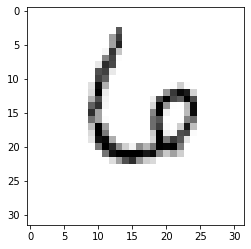

[[3.69011241e-06 4.86766960e-10 7.79238718e-09 8.99345765e-10
  4.06367144e-06 1.11319727e-08 9.99992132e-01 1.77385289e-08
  1.12906015e-07 1.35950522e-08]]


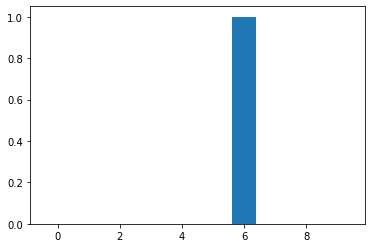

In [33]:
single_inference(model_file)

### Invoke the model for the whole training set

In [62]:
def predict(tfl_model_file, x=x_test_normalized):
    
    model = tf.lite.Interpreter(tfl_model_file)
    model.allocate_tensors()
    
    # model_input = model.tensor(model.get_input_details()[0]["index"])
    # model_output = model.tensor(model.get_output_details()[0]["index"])
    
    predictions = np.empty((x_test_normalized.shape[0], 10), dtype=np.float32)
    input_details, output_details = get_details(tfl_model_file)

    
    for index, data in enumerate(x_test_normalized):
        input_data = [np.array(data, dtype=np.float32)]
        model.set_tensor(input_details[0]['index'], input_data)
        model.invoke()
        output_data = model.get_tensor(output_details[0]['index'])
        predictions[index] = output_data
        
    return predictions

In [35]:
%%script false --no-raise-error

# original predictions
tf_model_predictions = tf_model.predict(x_test_normalized)

In [36]:
%%script false --no-raise-error


tfl_model_predictions = predict(model_file)

### Compare the predictions of the selected converted model to the original

In [37]:
%%script false --no-raise-error

# Compare the result.
try:
    np.testing.assert_almost_equal(tf_model_predictions, tfl_model_predictions, decimal=10)
except AssertionError as err:
    print(err)

### Compare model accuracy and losses

Define loss functions

In [38]:
# categorical crossentropy is the loss function which was used for training
loss_fn_crossentropy = tf.keras.losses.CategoricalCrossentropy(reduction='sum_over_batch_size')

loss_fn_meansquared = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

Define function which calculates the accuracy

In [39]:
def accuracy(tfl_model_predictions, y=y_test):
    accurate_count = 0

    for index in range(len(tfl_model_predictions)):
        if np.argmax(tfl_model_predictions[index]) == np.argmax(y[index]):
            accurate_count += 1

    model_accuracy = accurate_count * 1.0 / len(tfl_model_predictions)
    
    return model_accuracy

In [64]:
%%script false --no-raise-error


tfl_model_accuracy = accuracy(tfl_model_predictions)
tfl_crossentropy_loss = loss_fn_crossentropy(y_test, tfl_model_predictions).numpy()


print("TF Lite Model Accuracy:\t\t", tfl_model_accuracy)
print('Original model accuracy:\t', tf_model_accuracy)

print("TF Lite Model cross entropy loss:\t", tfl_crossentropy_loss)
print('Original model cross entropy loss:\t', tf_model_loss)

TF Lite Model Accuracy:		 0.9813
Original model accuracy:	 0.9879000186920166
TF Lite Model cross entropy loss:	 0.072569594
Original model cross entropy loss:	 0.04126233980059624
